In [3]:
# Imports

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# donwload the dataset

from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


In [5]:
train_data.shape

(404, 13)

In [6]:
# scale of targets is 1,000$

train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [7]:
# normalize each feature to bring them to a similar scale

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

**Note**: The quantities used for normalizing the test data is computed using the training data. I learnt that the reason is, if the test data is used in any part of the training process (e.g., to compute normalization parameters), the model can indirectly "**see**" the test data. This can lead to a model that performs well on the test set but poorly on new, unseen data.

However I find it not logical that I do not use test_data values to normalize test_data. It makes sense to think if I use test_data metrics to average training_data, it would introduce some error but how can using test_data metrics to normalize test_data only cause any data leak?

If anyone could help me here, that would be truly appreciated! :)

In [8]:
# build and comoile the model

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)])

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

In [11]:
# Since the data available is less, we can use K-fold cross validation to
# accurately evaluate our model based on the average of the validation scores for each fold

K = 4
num_val_samples = len(train_data) // K
num_epochs = 100
all_scores = []

for i in range(K):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [12]:
all_scores

[1.9344850778579712,
 2.5487148761749268,
 2.5238633155822754,
 2.3726067543029785]

In [13]:
np.mean(all_scores)

2.344917505979538

In [14]:
# we try with higher epochs to check if we can achieve better performance

num_epochs = 500
all_mae_histories = []
for i in range(K):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)

    # record MAE metric after each epoch for all the folds
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [24]:
# compute the average MAE score for all folds across a specific epoch

avg_mae = [np.mean([x[i] for x in all_mae_histories]) for i in range(500)]

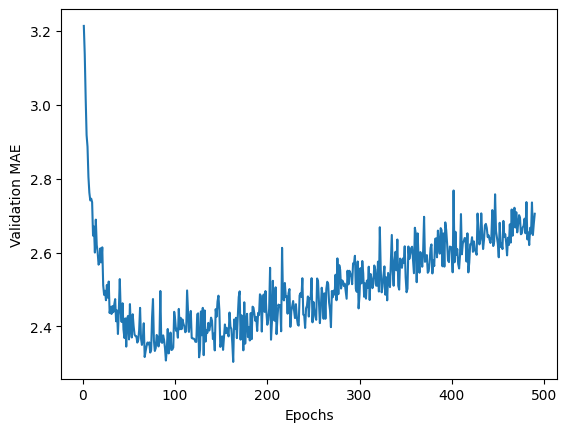

In [27]:
plt.plot(range(1, len(avg_mae[10:]) + 1), avg_mae[10:])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

We observe overfitting starts at around epoch 130, so we train a new model upto 130 epochs with the entire training set and evaluate test set.

In [28]:
model = build_model()
history = model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

In [29]:
model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 9ms/step - loss: 15.6402 - mae: 2.4592


[15.64021110534668, 2.4592041969299316]